In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#for collaborative filtering
import os
import math
import random

from surprise import Reader, Dataset
from surprise import NormalPredictor, KNNBasic
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.dump import dump
from surprise.dump import load
from surprise import SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [2]:
pd.options.display.float_format = '{:.2f}'.format
r = pd.read_csv('Downloads/ratings (1).csv')
b = pd.read_csv('Downloads/books_cleaned.csv')

In [3]:
def simple_recommender(books, n=5):
    v = books['ratings_count']
    m = books['ratings_count'].quantile(0.95)
    R = books['average_rating']
    C = books['average_rating'].median()
    score = (v/(v+m) * R) + (m/(m+v) * C)   
    books['score'] = score
    
    qualified  = books.sort_values('score', ascending=False)
    return qualified[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','score']].head(n)

In [4]:
simple_recommender(b)

,book_id,title,authors,average_rating,ratings_count,score
21,25,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,4.61,1746574,4.56
23,27,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1678823,4.49
15,18,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.53,1832823,4.49
20,24,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.53,1753043,4.48
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.44,4602479,4.43


In [5]:
def content(books):
    books['content'] = (pd.Series(books[['authors', 'title', 'genres', 'description']]
                                  .fillna('')
                                  .values.tolist()
                                  ).str.join(' '))
    tf_content = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
    tfidf_matrix = tf_content.fit_transform(books['content'])
    cosine = linear_kernel(tfidf_matrix, tfidf_matrix)
    index = pd.Series(books.index, index=books['title'])
    return cosine, index

In [6]:
def content_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n + 1]
    book_indices = [i[0] for i in sim_scores]
    return books[['book_id', 'title', 'authors', 'average_rating', 'ratings_count']].iloc[book_indices]

In [7]:
content_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,4.26,116197
2048,2187,We,Yevgeny Zamyatin,3.95,40020
3670,4004,Homage to Catalonia,George Orwell,4.14,22227
6857,8056,"1Q84 #1-2 (1Q84, #1-2)",Haruki Murakami,4.07,8342
4915,5510,The Far Side Gallery,Gary Larson,4.42,20022


In [8]:
def improved_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    books2 = books.iloc[book_indices][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    v = books2['ratings_count']
    m = books2['ratings_count'].quantile(0.75) #here the minimum rating is quantile 75
    R = books2['average_rating']
    C = books2['average_rating'].median()
    books2['new_score'] = (v/(v+m) * R) + (m/(m+v) * C)
    high_rating = books2[books2['ratings_count'] >= m]
    high_rating = high_rating.sort_values('new_score', ascending=False)
    return high_rating[['book_id', 'title', 'authors', 'average_rating', 'ratings_count']].head(n)

In [21]:
improved_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,4.26,116197
759,809,Brave New World / Brave New World Revisited,Aldous Huxley,4.16,108124
604,649,1Q84,Haruki Murakami,3.89,125195
8168,14,Animal Farm,George Orwell,3.87,1881700
265,293,Treasure Island,Robert Louis Stevenson,3.82,268012


In [6]:
# to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(r, reader)

# shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

# split data into train and test data with the ratio 70:30
threshold = int(0.7 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

In [7]:
# prepare train data
data.raw_ratings = train_ratings

# select algorithm
npred = NormalPredictor()

In [34]:
%%time
# cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=2)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3239  1.3218  1.3236  1.3237  1.3250  1.3236  0.0010  
Fit time          3.86    4.64    5.32    4.70    4.23    4.55    0.49    
Test time         11.83   7.67    10.12   7.51    6.03    8.63    2.07    
CPU times: total: 1min 7s
Wall time: 2min 2s


In [37]:
%%time
# retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)

Train RMSE:
RMSE: 1.3228
Test RMSE:
RMSE: 1.3216
CPU times: total: 54.1 s
Wall time: 59.6 s


In [44]:
# to dump the calculation result for future use
dump('./dump_np', predictions=np_test_pred, algo=npred)
# dump.dump('./dump_np', np_test_pred, npred)

KNNBasic

In [47]:
# change data to trainset
data.raw_ratings = train_ratings 

# select algorithm
sim_options = {"name": "cosine",
               "user_based": False}
knn = KNNBasic(sim_options=sim_options)

In [48]:
%%time
# cross validation for train data
knn_result = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True, n_jobs = 1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8879  0.8878  0.8868  0.8883  0.8867  0.8875  0.0007  
Fit time          54.99   56.11   59.11   57.08   55.66   56.59   1.43    
Test time         85.69   98.25   83.80   115.84  76.59   92.03   13.80   
CPU times: total: 9min 8s
Wall time: 13min 19s


In [49]:
%%time

# retrain whole train test
trainset = data.build_full_trainset()
knn.fit(trainset)

# compute RMSE on trainset (without fold)
knn_train_pred = knn.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(knn_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
knn_test_pred = knn.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(knn_test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Train RMSE:
RMSE: 0.8001
Test RMSE:
RMSE: 0.8851
CPU times: total: 9min 19s
Wall time: 11min 31s


In [50]:
# to dump the calculation result for future use
dump('./dump_knn', knn_test_pred, knn)

SVD

In [10]:
# change data to trainset
data.raw_ratings = train_ratings

# select algorithm
svd = SVD(random_state=0)

In [11]:
%%time
# cross validation for train data
svd_result = cross_validate(svd, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8503  0.8500  0.8484  0.8503  0.8510  0.8500  0.0009  
Fit time          41.55   41.77   39.61   39.88   32.86   39.13   3.25    
Test time         14.16   13.58   9.45    10.65   7.86    11.14   2.40    
CPU times: total: 1min 22s
Wall time: 3min 31s


In [12]:
%%time

# retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)

Train RMSE:
RMSE: 0.6441
Test RMSE:
RMSE: 0.8386
CPU times: total: 2min 23s
Wall time: 2min 37s


In [14]:
# to dump the calculation result for future use
dump('./dump_svd', svd_test_pred, svd)

SVD++

In [17]:
# change data to trainset
data.raw_ratings = train_ratings 

# select algorithm
svdpp = SVDpp(random_state=0)

In [18]:
%%time
svdpp_result = cross_validate(svdpp, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8322  0.8332  0.8326  0.8328  0.8326  0.8327  0.0003  
Fit time          370.05  369.35  374.52  371.27  550.10  407.06  71.54   
Test time         87.19   86.32   82.33   80.97   51.73   77.71   13.20   
CPU times: total: 1min 11s
Wall time: 25min 56s


In [19]:
%%time
# retrain whole train test
trainset = data.build_full_trainset()
svdpp.fit(trainset)

# compute RMSE on trainset (without fold)
svdpp_train_pred = svdpp.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdpp_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdpp_test_pred = svdpp.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdpp_test_pred)

Train RMSE:
RMSE: 0.7085
Test RMSE:
RMSE: 0.8238
CPU times: total: 15min 43s
Wall time: 17min 40s


In [20]:
# uncomment this code to dump the calculation result for future use
dump('./dump_svdpp', svdpp_test_pred, svdpp)

In [24]:
# load the dump file
np_test_pred, npred = load('./dump_np')
knn_test_pred, knn = load('./dump_knn')
svd_test_pred, svd = load('./dump_svd')
svdpp_test_pred, svdpp = load('./dump_svdpp')

In [25]:
# making the calculation result into dataframe
df_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_knn = pd.DataFrame(knn_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])  
df_svdpp = pd.DataFrame(svdpp_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

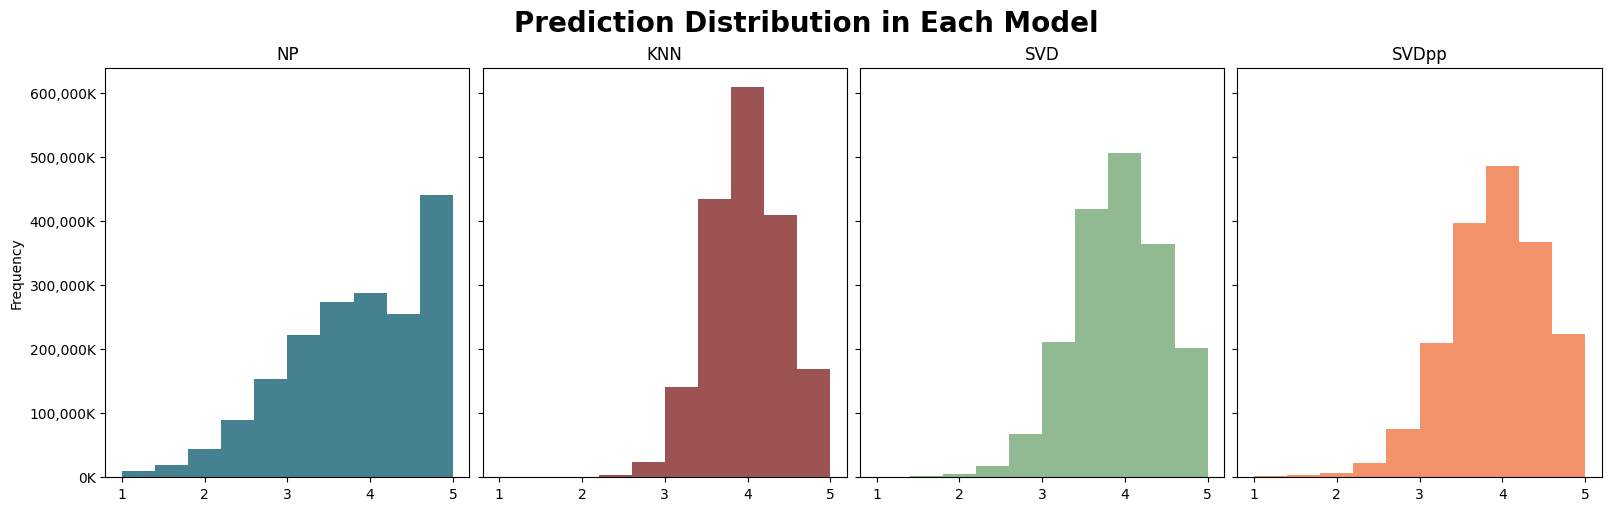

In [65]:
# count the number of predictions for each rating value
figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(16, 5), sharey=True, constrained_layout=True)
df_np.est.plot(kind='hist', title='NP', ax=ax1, color='#45818E')
df_knn.est.plot(kind='hist', title='KNN', ax=ax2, color='#9D5353')
df_svd.est.plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
df_svdpp.est.plot(kind='hist', title='SVDpp', ax=ax4, color='#F3936B')
# Set y-tick labels with K formatting
ax1.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()])
ax2.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()])
ax3.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax3.get_yticks()])
ax4.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax4.get_yticks()])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=20)
plt.show()

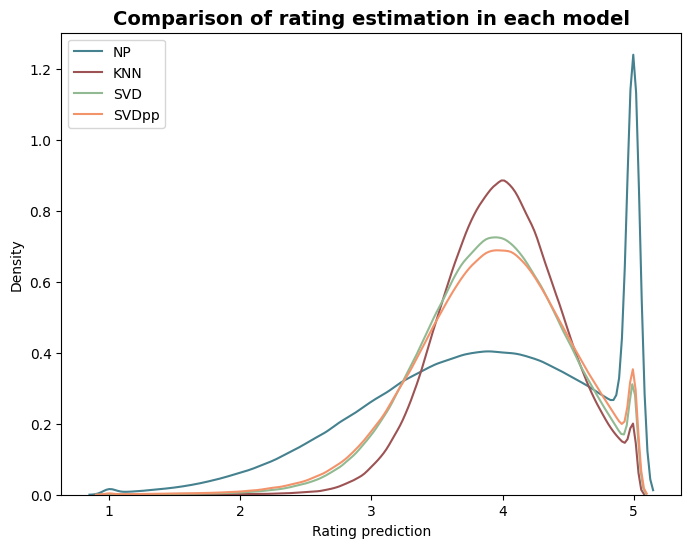

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_np['est'], fill=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(df_knn['est'], fill=False, color='#9D5353', label = 'KNN', ax=ax)
sns.kdeplot(df_svd['est'], fill=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdpp['est'], fill=False, color='#F3936B', label = 'SVDpp', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

Making recommendation

In [28]:
def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(b['book_id'])
    book_read_list = list(r['book_id'][r['user_id'] == user_id])
    return books_list, book_read_list

In [29]:
data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

In [30]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [31]:
get_recommendation_npred(12874, 5)

,book_id,title,authors,average_rating,ratings_count
21,25,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,4.61,1746574
26,30,Gone Girl,Gillian Flynn,4.03,512475
42,49,"New Moon (Twilight, #2)",Stephenie Meyer,3.52,1149630
80,89,The Princess Bride,William Goldman,4.25,628637
81,90,The Outsiders,S.E. Hinton,4.06,659248


Using KNN Model

In [32]:
data.raw_ratings = all_ratings
knn.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = knn.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [34]:
get_recommendation_knn(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
89,98,"The Girl Who Played with Fire (Millennium, #2)",Stieg Larsson,4.22,563994
103,114,Tuesdays with Morrie,Mitch Albom,4.06,556518
118,132,The Five People You Meet in Heaven,Mitch Albom,3.90,449501
126,140,The Girl Who Kicked the Hornet's Nest (Millenn...,Stieg Larsson,4.20,443951


Using SVD

In [35]:
%%time
# make recommendation on full dataset
data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

CPU times: total: 1min 39s
Wall time: 1min 52s


In [36]:
def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svd.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [37]:
get_recommendation_svd(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
194,215,Ready Player One,Ernest Cline,4.31,349423
226,250,Wonder,R.J. Palacio,4.43,228538
390,425,Go Ask Alice,Beatrice Sparks,3.77,196677
1698,1808,"Morning Star (Red Rising, #3)",Pierce Brown,4.50,47736


Using SVD++

In [38]:
%%time

# make recommendation on full dataset
data.raw_ratings = all_ratings
svdpp.fit(data.build_full_trainset()) 

CPU times: total: 15min 21s
Wall time: 17min 56s


In [39]:
def get_recommendation_svdpp(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdpp.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [40]:
get_recommendation_svdpp(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
597,642,"World Without End (The Kingsbridge Series, #2)",Ken Follett,4.23,128715
1243,1328,"I Am Pilgrim (Pilgrim, #1)",Terry Hayes,4.23,49740
4310,4778,The Holy Bible: English Standard Version,Anonymous,4.66,17863
5302,5990,الطنطورية,Radwa Ashour,4.32,13931


Hyperparameter Tuning

In [41]:
# prepare train data
data.raw_ratings = train_ratings

In [44]:
%%time
grid = {'n_epochs': [20, 30], 
        'lr_all': [.005, .001], 
        'reg_all': [0.02, 0.04]} 
gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=5, n_jobs=2)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8384981481897436
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.04}
CPU times: total: 2min 34s
Wall time: 24min 29s


In [45]:
# select best algorithm
svdtuned = gs.best_estimator['rmse']

In [46]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

# compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

Train RMSE:
RMSE: 0.6577
Test RMSE:
RMSE: 0.8273
CPU times: total: 3min 33s
Wall time: 12min 37s


In [47]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

CPU times: total: 2min 31s
Wall time: 3min 18s


In [48]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [49]:
get_recommendation(12874, 5)

,book_id,title,authors,average_rating,ratings_count
241,267,The Nightingale,Kristin Hannah,4.54,253606
387,422,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74,190050
810,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77,73572
7466,8946,The Divan,Hafez,4.63,2773
8909,6246,The Crippled God (The Malazan Book of the Fall...,Steven Erikson,4.44,14472


In [56]:
# uncomment this code to dump the calculation result for future use
dump('./dump_tuning', svdtuned_test_pred, svdtuned)

In [57]:
# uncomment this code to load the dump file
svd_test_pred, svd = load('./dump_svd')
svdtuned_test_pred, svdtuned = load('./dump_tuning')

In [58]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

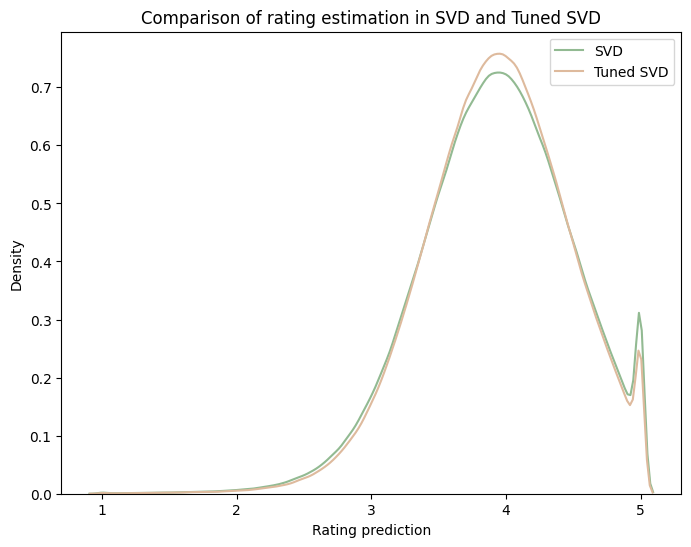

In [60]:
# visualization
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], fill=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], fill=False, color='#DEBA9D', label = 'Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()